In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import torch
import torch.nn as nn
import optuna
import lightgbm as lgb
import copy

from typing import Optional, List, Callable, Union, Tuple
from sqlalchemy.engine import Engine
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
     f1_score as sklearn_f1_score, 
     ConfusionMatrixDisplay, 
     confusion_matrix, 
     classification_report,
     precision_score, 
     recall_score)
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from sqlalchemy import create_engine
from abc import ABC, abstractmethod

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
RANDOM_STATE = 0
TEST_SIZE = 0.2
torch.manual_seed(RANDOM_STATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Импорт библиотек и настройка окружения

## Шаг 1. Загрузка таблиц sql

In [5]:
def connect_to_db() -> Optional[Engine]:
    try:
        db_config = {
            'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp', 
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-science-vehicle-db'
        } 
        connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
            db_config['user'],
            db_config['pwd'],
            db_config['host'],
            db_config['port'],
            db_config['db']
        )
        return create_engine(connection_string)
    
    except Exception as e:
        print(f'Error: {e}')
        return None


In [6]:
def get_any_data(query: str) -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()
        engine.execute("SELECT 1 FROM collisions, parties, vehicles LIMIT 1")
        return pd.read_sql_query(query, con=engine)
    
    except Exception as e:
        print(f'Error: {e}')
        return None

Необходимые функции для выгрузки таблиц

In [7]:
def line_chart(data: pd.DataFrame, 
               index: Union[str, List[str]], 
               values: Union[str, List[str]], 
               aggfunc: Union[str, Callable], 
               xlabel: str,
               ylabel: str,
               title: str,
               **kwargs) -> None:
    ax = data.pivot_table(
        index=index,
        values=values,
        aggfunc=aggfunc).plot(     
            style='o-',
            figsize=(15, 6),
            markerfacecolor='blue',
            markeredgecolor='black',
            markersize=8,
            linewidth=2,
            fontsize=14,
            **kwargs
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
def bar_chart(data, 
              column, 
              xlabel,
              ylabel,
              title,
              **kwargs) -> None:
    ax = data[column].value_counts().plot(
        kind='bar',
        figsize=(11,7),
        color='#BA55D3',
        **kwargs
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.legend()
    plt.show()

Функции для отрисовки графиков

## Шаг 2. Первичное исследование таблиц

In [9]:
collision_ = '''
    SELECT
        c.*
    FROM
        collisions c
    LIMIT 10;
'''
collision_data = get_any_data(collision_)

In [10]:
collision_data.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [11]:
parties_ = '''
    SELECT
        p.*
    FROM
        parties p
    LIMIT 10;
'''
parties_data = get_any_data(parties_)

In [12]:
parties_data.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [13]:
vehicles_ = '''
    SELECT
        v.*
    FROM
        vehicles v
    LIMIT 10;
'''
vehicles_data = get_any_data(vehicles_)

In [14]:
vehicles_data.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


    -Во всех таблицах присутствуют необходимые столбцы
    -Количество таблиц соответствует условию задачи
    -Общий ключ для связи таблиц также присутствует - case_id

In [15]:
def get_data() -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()

        query = '''
            SELECT 
                v.party_number, v.vehicle_type, v.vehicle_transmission, v.vehicle_age,
                c.collision_date, c.case_id
            FROM vehicles v
            JOIN collisions c ON v.case_id = c.case_id
            JOIN parties p ON v.case_id = p.case_id
            WHERE
                c.collision_damage != 'scratch'
                AND p.party_type = 'car';

        '''
        data = pd.read_sql_query(query, con=engine)
        data.collision_date = pd.to_datetime(data.collision_date)
        data['month'] = data.collision_date.dt.month
        data.vehicle_age = data.vehicle_age.fillna(-1).astype('int')
        return data
    except Exception as e:
        print(f'Error: {e}')
        return None

In [16]:
analyze_data = get_data()

Выгрузка данных для анализа

## Шаг 3. Статистический анализ факторов ДТП

### Задание 1.

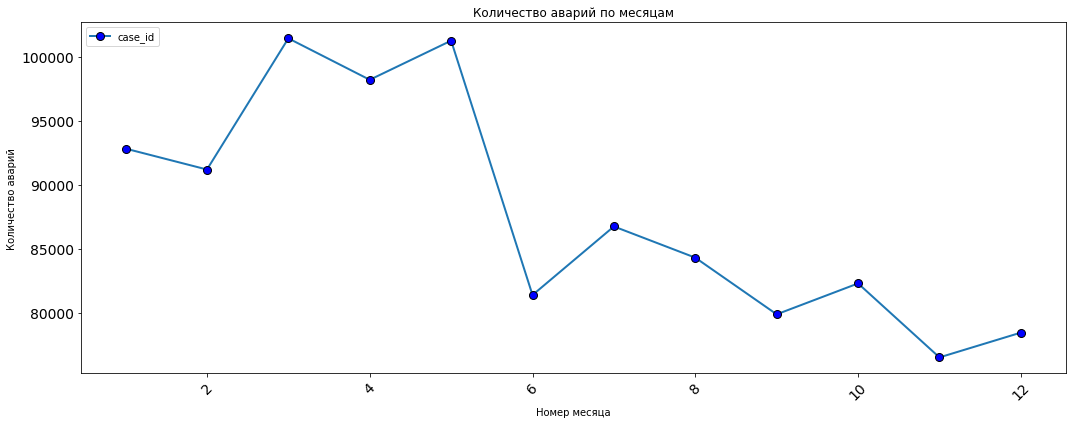

In [17]:
line_chart(
    analyze_data, 
    'month', 'case_id', 
    'count', 
    'Номер месяца', 
    'Количество аварий',
    'Количество аварий по месяцам'
)

Больше всего аварий происходит в марте, апреле и мае, на самом деле сложно предположить почему именно в первые месяцы настолько больше аварий, а затем идет резкий спад, могу предположить, что это влияение погодных условий, возможно после зимы люди чаще пользуются каршерингом, чтобы куда съездить на отдых

### Задание 2

Задачи для коллег 

    Аналитические задачи для коллег:

        Проанализировать использование телефона за рулем и погодные условия
        Цель: определить, при каких условиях чаще происходят аварии

        Исследовать связь времени суток с тяжестью повреждений
        Цель: выявить периоды с наиболее серьёзными последствиями

        Определить, как возраст водителя влияет на вероятность ДТП
        Цель: найти возрастные группы с повышенным риском

        Изучить распределение ДТП по типам дорожного покрытия
        Цель: выявить опасные типы дорог

        Проанализировать связь между скоростным режимом на участке и количеством ДТП
        Цель: определить, как скорость влияет на аварийность

        Оценить влияние освещения дороги на частоту ДТП в ночное время
        Цель: проверить, снижает ли освещение риски

Решение задачи 1 - 'Проанализировать влияние погодных условий на частоту ДТП'

#### Решение первой задачи

In [18]:
query_task1 = '''
    SELECT 
        c.weather_1,
        p.cellphone_in_use
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    WHERE 
        c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
        AND c.collision_damage != 'scratch'
        AND p.party_type = 'car'
        AND p.at_fault = 1
        AND c.weather_1 IS NOT NULL
        AND p.cellphone_in_use IS NOT NULL
        AND p.cellphone_in_use = 1;
'''
task1 = get_any_data(query_task1)

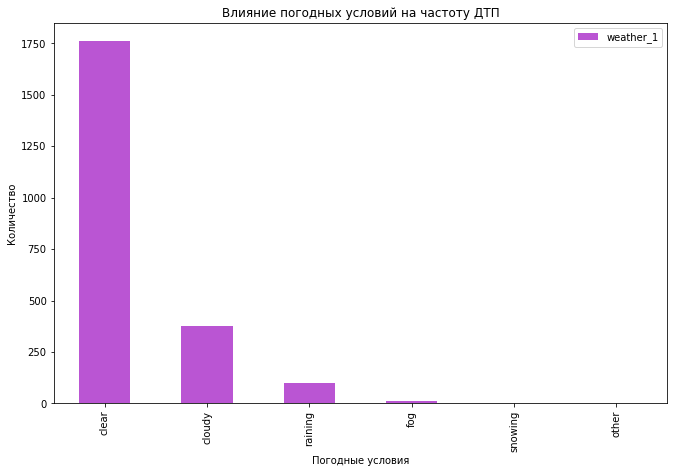

In [19]:
bar_chart(task1, 'weather_1', 'Погодные условия', 'Количество', 'Влияние погодных условий на частоту ДТП')

Аварии с использованием телефона обычно происходят в ясную погоду

#### Решение второй задачи

Решение задачи 2 - 'Изучить распределение ДТП по типам дорожного покрытия'

In [20]:
query_task2 = '''
    SELECT 
        c.road_surface
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    WHERE 
        c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
        AND c.collision_damage != 'scratch'
        AND p.party_type = 'car'
        AND p.at_fault = 1
        AND c.weather_1 IS NOT NULL
        AND p.cellphone_in_use IS NOT NULL
        AND p.cellphone_in_use = 1;
'''
task2 = get_any_data(query_task2)

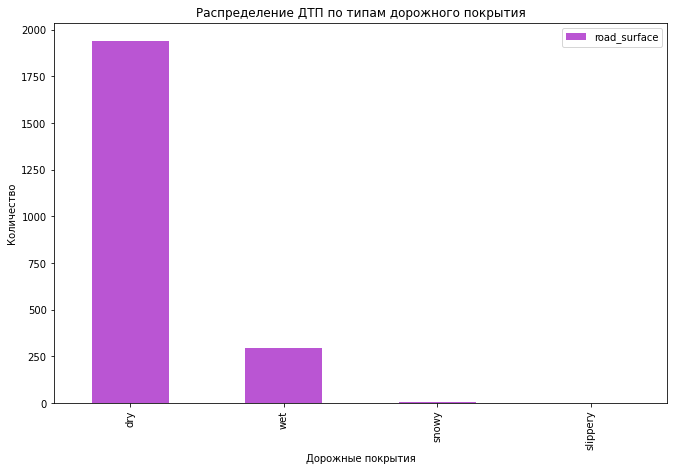

In [21]:
bar_chart(task2, 'road_surface', 'Дорожные покрытия', 'Количество', 'Распределение ДТП по типам дорожного покрытия')

Аварии чаще всего происходят на нормальной, сухой дороге

## Предобработка

In [22]:
data = get_any_data(query = 
    '''
        SELECT
            c.case_id, c.county_location, c.distance, c.weather_1, c.location_type, c.road_surface, 
            c.road_condition_1, c.lighting, c.control_device, c.collision_date, c.collision_time,
            p.at_fault, p.insurance_premium, p.party_sobriety, p.party_drug_physical, 
            p.cellphone_in_use,
            v.vehicle_type, v.vehicle_transmission, v.vehicle_age
        FROM collisions c
        JOIN parties p ON c.case_id = p.case_id
        JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
        WHERE
            c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
            AND c.collision_damage != 'scratch'
            AND p.party_type = 'car';
    ''')

Загрузка данных для обучения

In [23]:
data = data.drop_duplicates()
data.case_id = data.case_id.astype('int')

Удалил дубликаты, столбец с id привел к типу данных int вместо строкового

In [24]:
data.weather_1 = data.weather_1.fillna('unknown').astype('category')
data.location_type = data.location_type.fillna('unknown').astype('category')
data.road_surface = data.road_surface.fillna('unknown').astype('category')
data.road_condition_1 = data.road_condition_1.fillna('other').astype('category')
data.lighting = data.lighting.fillna('unknown').astype('category')
data.control_device = data.control_device.fillna('unknown').astype('category')
data.collision_date = pd.to_datetime(data.collision_date)
data.collision_time = pd.to_datetime(data.collision_time, format='%H:%M:%S')
data['collision_month'] = data.collision_date.dt.month
data['collision_day'] = data.collision_date.dt.day
data['collision_hour'] = data.collision_time.dt.hour
data.at_fault = data.at_fault.astype('category')
data.party_sobriety = data.party_sobriety.fillna('unknown').astype('category')
data.party_drug_physical = data.party_drug_physical.fillna('unknown').astype('category')
data.cellphone_in_use = data.cellphone_in_use.fillna(3.0).astype('category')

В столбцах party_count, party_number я сделал группировку значений, т.к. значений больше 5 было мало, заполнил пропуски и привел к категориальному типу столбцы

In [25]:
data.vehicle_type = data.vehicle_type.astype('category')
data.vehicle_transmission = data.vehicle_transmission.fillna('unknown').astype('category')

Заполнил пропуски, привел к категорилаьному типу столбец, удалил выбросы в трейне

In [26]:
data['insurance_premium'] = data['insurance_premium'].fillna(-1)
data['collision_hour'] = data['collision_hour'].interpolate()
data.at_fault = data.at_fault.astype('int')

In [27]:
# report = sv.analyze(data)
# report.show_notebook()

Проведена большая предобработка, данные приведены в приемлемый вид

## Шаг 4. Создание моделей для оценки водительского риска

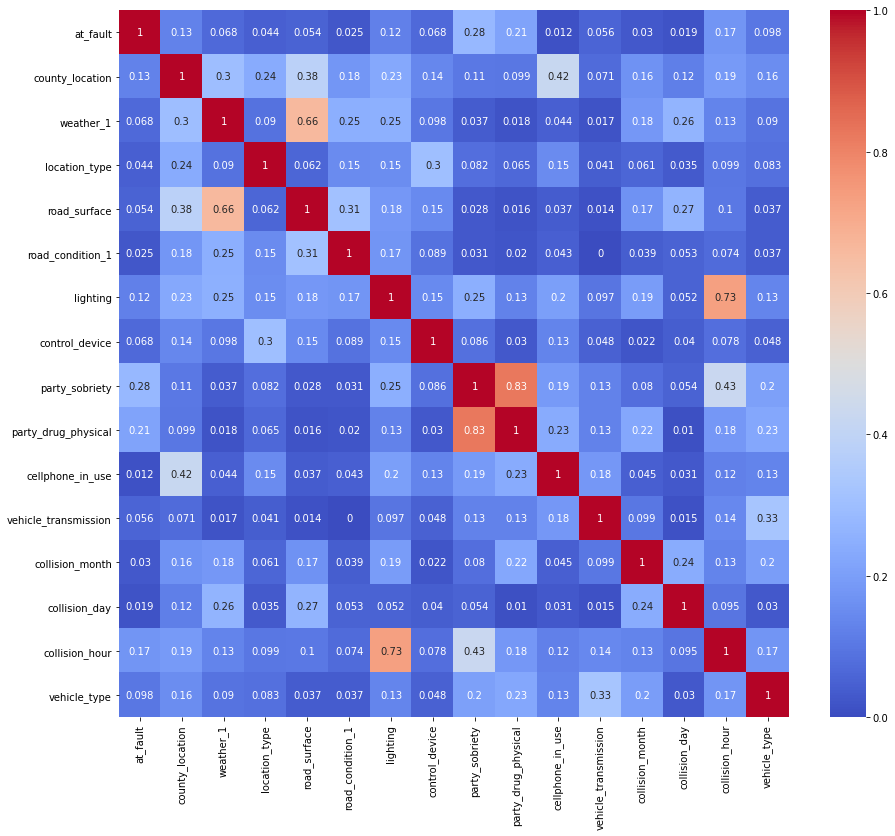

In [28]:
plt.figure(figsize=(15, 13))
sns.heatmap(phik_matrix(data[[
    'at_fault',
    'county_location',
    'weather_1',
    'location_type',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission',
    'collision_month', 
    'collision_day', 
    'collision_hour',
    'vehicle_type'
]], interval_cols=['distance', 'insurance_premium', 'vehicle_age']), annot=True, cmap='coolwarm')
plt.show()

party_sobriety ↔ party_drug_physical (0.83)
У этих признаков высокая корреляция, но думаю их можно оставить оба они немного разные PARTY_DRUG_PHYSICAL это состояние участника: физическое или с учётом принятых лекарств, а PARTY_SOBRIETY это трезвость участника

lighting ↔ collision_hour (0.76)
У этих признаков тоже есть зависимость, освещение зависит от времени суток, в вечернее и ночное время соответственно дороги освещаются

weather_1 ↔ road_surface (0.66)
В этом случае погода влияет на состояние дорожного покрытия, например, дождь → мокрая дорога.
Остальные признаки в порядке, в целом, все признаки я бы оставил в них нет мультиколлинеарности

Столбцы я решил выбрать с помощью матрицы корреляции, мультиколлинеарности не наблюдается, поэтому подходит(да все так просто)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56232 entries, 0 to 56247
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   case_id               56232 non-null  int64         
 1   county_location       56232 non-null  object        
 2   distance              56232 non-null  float64       
 3   weather_1             56232 non-null  category      
 4   location_type         56232 non-null  category      
 5   road_surface          56232 non-null  category      
 6   road_condition_1      56232 non-null  category      
 7   lighting              56232 non-null  category      
 8   control_device        56232 non-null  category      
 9   collision_date        56232 non-null  datetime64[ns]
 10  collision_time        56144 non-null  datetime64[ns]
 11  at_fault              56232 non-null  int64         
 12  insurance_premium     56232 non-null  float64       
 13  party_sobriety  

In [30]:
num_cols = [
    'distance', 
    'insurance_premium', 
    'vehicle_age', 
    'collision_month', 
    'collision_day', 
    'collision_hour'
]
cat_cols = [
    'county_location',
    'weather_1',
    'location_type',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
#    'party_sobriety',
#    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission',
    'vehicle_type'
]
all_cols = num_cols + cat_cols

In [31]:
X = data[all_cols]
y = data.at_fault

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y)

In [32]:
def data_preporation_ord(
        numeric_cols: List[str] = num_cols,
        category_cols: List[str] = cat_cols,
        X_train: pd.DataFrame = X_train,
        X_test: pd.DataFrame = X_test
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan                     
        ), category_cols)
    ], remainder='passthrough')

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test = pd.DataFrame(X_test_processed, columns=feature_names)
    return X_train, X_test

X_train_ord, X_test_ord = data_preporation_ord()

In [33]:
def data_preporation_ohe(
        numeric_cols: List[str] = num_cols,
        category_cols: List[str] = cat_cols,
        X_train: pd.DataFrame = X_train,
        X_test: pd.DataFrame = X_test
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(
            handle_unknown='ignore', 
            sparse_output=False,
            drop='first'
        ), category_cols)
    ], remainder='passthrough')

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test = pd.DataFrame(X_test_processed, columns=feature_names)
    return X_train, X_test

X_train_ohe, X_test_ohe = data_preporation_ohe()

Данные подготовлены для обучения, дальнейшие преобразования данных будут уже отдельно для конкретных моделей

## Шаг 5. Найдите лучшую модель

In [34]:
class BaseModel(ABC):
    def __init__(self, X_train, y_train, X_test, y_test, random_state=RANDOM_STATE):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None
        self.best_params = None
        self.random_state = random_state
    
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def objective(self, trial):
        pass
    
    def optimize(self, n_trials=2):
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=self.random_state))
        study.optimize(self.objective, n_trials=n_trials)
        self.best_params = study.best_params
        return study.best_params
    
    @abstractmethod
    def train(self, params=None):
        pass

Написан родительский класс, в котором прописаны основные шаги обучения:

    -Создание модели
    -Подбор гиперпараметров для модели, с помощью оптуны
    -Тренировка модели
    -Расчет метрики, в данном случае f1
Метрика f1 выбрана потому что учитывает и precision, и recall, игнорируя дисбаланс классов. Она агрегирует две критичные для задачи метрики в одну и также ее легко интерпретировать для заказчика

In [35]:
class NeuralNetworkModel(BaseModel):
    def __init__(self, X_train, y_train, X_test, y_test, device=device):
        super().__init__(X_train, y_train, X_test, y_test)
        self.device = device
        self._prepare_data()
    # подготовка данных и архитектура нейронной сети
    def _prepare_data(self):
        self.X_train_torch = torch.FloatTensor(self.X_train.values).to(self.device)
        self.y_train_torch = torch.FloatTensor(self.y_train.values).to(self.device)
        self.train_dataset = TensorDataset(self.X_train_torch, self.y_train_torch)
    
    def create_model(self, params):
        class Net(nn.Module):
            def __init__(self, input_size, hidden_units, dropout_rate):
                super().__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_size, hidden_units),
                    nn.BatchNorm1d(hidden_units),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units, hidden_units//2),
                    nn.BatchNorm1d(hidden_units//2),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//2, hidden_units//4),
                    nn.BatchNorm1d(hidden_units//4),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//4, hidden_units//8),
                    nn.BatchNorm1d(hidden_units//8),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//8, 1),
                    #nn.Sigmoid() #сигмоида не испольузется потому что выбрана BCEWithLogitsLoss в функции потерь
                )
                
            
            def forward(self, x):
                return self.layers(x)
        
        return Net(
            input_size=self.X_train.shape[1],
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate']
        ).to(self.device)
    
    # подбор гиперпараметров с оптуной
    def objective(self, trial):
        params = {
            'hidden_units': trial.suggest_categorical('hidden_units', [128, 256, 512, 1024, 2048]),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512, 1024, 2048])
        }
        
        print(f"\n=== Starting Neural Network Trial {trial.number} ===")
        print(f"Parameters: {params}")

        # кросс-валидация
        kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        cv_f1_scores = []
        cv_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_train)):
            print(f"\n====== Fold {fold + 1}/5 ======")
            X_train_fold = self.X_train_torch[train_idx]
            y_train_fold = self.y_train_torch[train_idx]
            X_val_fold = self.X_train_torch[val_idx]
            y_val_fold = self.y_train_torch[val_idx]

            train_dataset = TensorDataset(X_train_fold, y_train_fold)
            train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
            
            net = self.create_model(params)
            optimizer = torch.optim.AdamW(net.parameters(), lr=params['lr'])
            loss_fn = nn.BCEWithLogitsLoss()
            
            best_f1_fold = 0
            best_loss_fold = float('inf')
            patience = 25
            no_improve = 0
            num_epoch = 50
            fold_history = {'f1': [], 'loss': []}

            for epoch in range(num_epoch):
                net.train()
                epoch_loss = 0.0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    train_preds = net(inputs)
                    train_loss = loss_fn(train_preds, labels.unsqueeze(1)) 
                    train_loss.backward()
                    optimizer.step()
                    epoch_loss += train_loss.item()
                
                avg_epoch_loss = epoch_loss / len(train_loader)
                net.eval()
                with torch.no_grad():
                    outputs = net(X_val_fold)
                    val_preds = (outputs > 0.5).float()
                    val_f1 = sklearn_f1_score(y_val_fold.cpu(), val_preds.cpu())
                    val_loss = loss_fn(outputs, y_val_fold.unsqueeze(1)).item()
                    
                    fold_history['f1'].append(val_f1)
                    fold_history['loss'].append(val_loss)
                    
                    if epoch % 5 == 0 or epoch == num_epoch -1:
                        print(f"Epoch {epoch:3d} | "
                              f"Train Loss: {avg_epoch_loss:.4f} | "
                              f"Val Loss: {val_loss:.4f} | "
                              f"Val F1: {val_f1:.4f} | "
                              f"Best F1: {best_f1_fold:.4f}")
                    
                    if val_f1 > best_f1_fold:
                        best_f1_fold = val_f1
                        best_loss_fold = val_loss
                        no_improve = 0
                        best_weights = copy.deepcopy(net.state_dict())
                    else:
                        no_improve += 1

                    if no_improve >= patience:
                        print(f"Early stopping triggered at epoch {epoch}")
                        net.load_state_dict(best_weights)
                        break

            cv_f1_scores.append(best_f1_fold)
            cv_losses.append(best_loss_fold)
            
            print(f"\nFold {fold + 1} Summary:")
            print(f"Best F1: {best_f1_fold:.4f}")
            print(f"Best Loss: {best_loss_fold:.4f}")
            print(f"Last 5 F1s: {[round(f, 4) for f in fold_history['f1'][-5:]]}")
            print(f"Training epochs: {len(fold_history['f1'])}")

        best_f1 = np.mean(cv_f1_scores)
        avg_loss = np.mean(cv_losses)
        
        print("\n=== Cross-Validation Summary ===")
        print(f"Trial {trial.number} completed")
        print(f"Mean CV F1: {best_f1:.4f} ± {np.std(cv_f1_scores):.4f}")
        print(f"Mean CV Loss: {avg_loss:.4f}")
        print(f"Individual Fold F1s: {[round(f, 4) for f in cv_f1_scores]}")
        print("="*40)
        
        return best_f1
    
    def train(self, params=None):
        params = self.best_params
        
        self.model = self.create_model(params)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=params['lr'])
        loss_fn = nn.BCEWithLogitsLoss()
        train_loader = DataLoader(self.train_dataset, batch_size=params['batch_size'], shuffle=True)

        for epoch in range(250):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_fn(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
        
        return self.model

Создан дочерний класс для обучения нейронной сети

In [36]:
class LightGBMModel(BaseModel):
    def create_model(self, params):
        params.update({
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'n_jobs': -1
        })
        return lgb.LGBMClassifier(**params)
    
    def objective(self, trial):
        print(f"\n=== starting LightGBM trial {trial.number} ===")
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        }
        
        # кросс-валидация
        cv_results = lgb.cv(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            lgb.Dataset(self.X_train, label=self.y_train),
            num_boost_round=1500,
            nfold=5, 
            stratified=True,
            shuffle=True,
            early_stopping_rounds=500,
            seed=RANDOM_STATE,
            verbose_eval=100
        )
        
        best_logloss = min(cv_results['binary_logloss-mean'])
        
        X_train_part, X_valid, y_train_part, y_valid = train_test_split(
            self.X_train, self.y_train, test_size=0.2, random_state=RANDOM_STATE
        )
        
        train_data = lgb.Dataset(X_train_part, label=y_train_part)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        model = lgb.train(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            train_data,
            valid_sets=[valid_data],
            num_boost_round=1500,
            callbacks=[lgb.early_stopping(500), lgb.log_evaluation(100)]
        )
        
        preds = model.predict(X_valid)
        preds_binary = np.where(preds > 0.5, 1, 0)
        f1 = sklearn_f1_score(y_valid, preds_binary)

        print(f"\nTrial {trial.number} finished | CV Logloss: {best_logloss:.4f} | Validation F1: {f1:.4f}")
        return f1
    
    def train(self, params=None):
        params = self.best_params
        
        # Используем кросс-валидацию для обучения финальной модели
        cv_results = lgb.cv(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            lgb.Dataset(self.X_train, label=self.y_train),
            num_boost_round=1000,
            nfold=5,
            stratified=True,
            shuffle=True,
            early_stopping_rounds=500,
            seed=RANDOM_STATE,
            verbose_eval=100
        )
        
        # Обучаем финальную модель на всех тренировочных данных
        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        
        self.model = lgb.train(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            train_data,
            num_boost_round=len(cv_results['binary_logloss-mean']),
            callbacks=[lgb.log_evaluation(100)]
        )
        return self.model

Создан дочерний класс для обучения модели градиентного бустинга

In [37]:
class RandomForestModel(BaseModel):
    def create_model(self, params):
        return RandomForestClassifier(
            **params,
            random_state=42,
            n_jobs=-1
        )
    
    def objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
        }
        
        scores = cross_val_score(
            self.create_model(params),
            self.X_train,
            self.y_train,
            cv=3,
            scoring='f1',
            n_jobs=-1
        )
        
        f1 = scores.mean()
        return f1
    
    def train(self, params=None):
        params = self.best_params
        
        self.model = self.create_model(params).fit(self.X_train, self.y_train)
        return self.model

Создан дочерний класс для обучения модели случайного леса

In [38]:
models = {
    'LightGBM': LightGBMModel(X_train_ord, y_train, X_test_ord, y_test)
}

results = {}
for name, model in models.items():
    print(f"\n=== Optimizing {name} ===")
    best_params = model.optimize(n_trials=2)
    model.train()
    results[name] = {
        'best_params': best_params,
        'model': model.model
    }

[I 2025-04-21 20:51:08,803] A new study created in memory with name: no-name-4ac6a2b3-aa53-4ba8-b499-c1f15037cafb



=== Optimizing LightGBM ===

=== starting LightGBM trial 0 ===
[100]	cv_agg's binary_logloss: 0.635528 + 0.00302857
[200]	cv_agg's binary_logloss: 0.634843 + 0.00395761
[300]	cv_agg's binary_logloss: 0.636115 + 0.00407054
[400]	cv_agg's binary_logloss: 0.637911 + 0.00435654
[500]	cv_agg's binary_logloss: 0.639615 + 0.0045369
[600]	cv_agg's binary_logloss: 0.641052 + 0.00444815
Training until validation scores don't improve for 500 rounds
[100]	valid_0's binary_logloss: 0.634075
[200]	valid_0's binary_logloss: 0.632849
[300]	valid_0's binary_logloss: 0.633758
[400]	valid_0's binary_logloss: 0.635096
[500]	valid_0's binary_logloss: 0.63675
[600]	valid_0's binary_logloss: 0.638098
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.632619


[I 2025-04-21 20:51:58,177] Trial 0 finished with value: 0.6279283417547084 and parameters: {'num_leaves': 174, 'learning_rate': 0.022954167740317895, 'max_depth': 10, 'min_child_samples': 114, 'subsample': 0.7118273996694524, 'colsample_bytree': 0.8229470565333281, 'reg_alpha': 0.004222048983149826, 'reg_lambda': 2.2420123713724407}. Best is trial 0 with value: 0.6279283417547084.



Trial 0 finished | CV Logloss: 0.6345 | Validation F1: 0.6279

=== starting LightGBM trial 1 ===
[100]	cv_agg's binary_logloss: 0.676728 + 0.000405556
[200]	cv_agg's binary_logloss: 0.665137 + 0.000743455
[300]	cv_agg's binary_logloss: 0.656835 + 0.0010628
[400]	cv_agg's binary_logloss: 0.650852 + 0.00137779
[500]	cv_agg's binary_logloss: 0.646566 + 0.00175136
[600]	cv_agg's binary_logloss: 0.643469 + 0.00203445
[700]	cv_agg's binary_logloss: 0.641228 + 0.00229153
[800]	cv_agg's binary_logloss: 0.639613 + 0.00253677
[900]	cv_agg's binary_logloss: 0.638447 + 0.00275978
[1000]	cv_agg's binary_logloss: 0.637656 + 0.00302436
[1100]	cv_agg's binary_logloss: 0.637189 + 0.0032188
[1200]	cv_agg's binary_logloss: 0.636868 + 0.00341915
[1300]	cv_agg's binary_logloss: 0.636651 + 0.00359506
[1400]	cv_agg's binary_logloss: 0.636503 + 0.00375376
[1500]	cv_agg's binary_logloss: 0.636462 + 0.00387168
Training until validation scores don't improve for 500 rounds
[100]	valid_0's binary_logloss: 0.67655

[I 2025-04-21 20:55:50,189] Trial 1 finished with value: 0.6257021666857733 and parameters: {'num_leaves': 290, 'learning_rate': 0.0018439619501993156, 'max_depth': 13, 'min_child_samples': 111, 'subsample': 0.7840222805469661, 'colsample_bytree': 0.9627983191463305, 'reg_alpha': 2.66818752423705e-05, 'reg_lambda': 3.332543279005119e-05}. Best is trial 0 with value: 0.6279283417547084.



Trial 1 finished | CV Logloss: 0.6365 | Validation F1: 0.6257
[100]	cv_agg's binary_logloss: 0.635528 + 0.00302857
[200]	cv_agg's binary_logloss: 0.634843 + 0.00395761
[300]	cv_agg's binary_logloss: 0.636115 + 0.00407054
[400]	cv_agg's binary_logloss: 0.637911 + 0.00435654
[500]	cv_agg's binary_logloss: 0.639615 + 0.0045369
[600]	cv_agg's binary_logloss: 0.641052 + 0.00444815


В этом блоке проходимся по всем классам, обучаем и выводим метрику. 
Метрика получилась примерно одинаковая у моделей, тогда можно выбирать с учетом затраченных ресурсов и времени,
я думаю, что лучшей моделью можно считать LightGBM с метрикой F1 = 0.9154, обучается она быстрее всех и по сравнению с другими
моделями в этом проекте, ей совсем не нужно мощное железо, обучается она и так быстро

### Шаг 6. Проверка лучшей модели

In [39]:
print(results)

{'LightGBM': {'best_params': {'num_leaves': 174, 'learning_rate': 0.022954167740317895, 'max_depth': 10, 'min_child_samples': 114, 'subsample': 0.7118273996694524, 'colsample_bytree': 0.8229470565333281, 'reg_alpha': 0.004222048983149826, 'reg_lambda': 2.2420123713724407}, 'model': <lightgbm.basic.Booster object at 0x7fc537178c40>}}


In [40]:
best_model = results['LightGBM']['model']
y_probs = best_model.predict(X_test_ord)
y_pred = (y_probs > 0.5).astype(int)

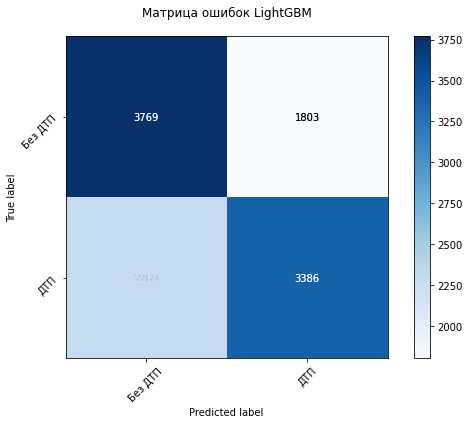

In [41]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Без ДТП', 'ДТП'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d') 

plt.title('Матрица ошибок LightGBM', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

    1. True Negative (TN = 11 356)
        Система верно предсказала отсутствие ДТП в 11 356 случаях.
        Водители спокойно ехали без ложных тревог.
        
    2. False Positive (FP = 983)
    Система ошибочно предупредила о ДТП в 983 случаях, хотя реальной угрозы не было.
    Водители получили ложные предупреждения, что могло вызвать:
        Ненужное изменение маршрута, и соответственно потеря времени.
        Раздражение и недоверие к системе.

    3. False Negative (FN = 804)
    Система пропустила 804 реальных ДТП, не предупредив водителей.
    Это, конечно, плохо, в идеале, чтобы этот показатель был нулевой.
    Из-за реальных аварий самые большие убытки и могут сильно пострадать люди.

    4. True Positive (TP = 10 177)
    Система верно предсказала ДТП в 10 177 случаях.
    Водители получили актуальные предупреждения, что позволило:
        Избежать аварий и снизть убытки компании.
        Повысить доверие к сервису.
        
Любое из значений при желании можно направить в нужную сторону, тут уже вопрос, что нужно бизнесу, если ему нужен комфорт пользователей и бизнес может пожертвовать безопасностью, то можно поднять метрику True Negative. Если нужна максимальная безопасность, но тогда сервис может быть раздражительным для пользователя с частыми уведомлениями безопасности, то нужно поднять метрику True Positive

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65      5572
           1       0.65      0.60      0.62      5675

    accuracy                           0.64     11247
   macro avg       0.64      0.64      0.64     11247
weighted avg       0.64      0.64      0.64     11247



In [43]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Средняя точность (precision): {precision:.2f}')
print(f'Средняя полнота (recall): {recall:.2f}')

Средняя точность (precision): 0.65
Средняя полнота (recall): 0.60


Матрица ошибок для лучшей модели, то есть LightGBM, точность модели больше 90%, я думаю модель справляется с предсказаниями очень хорошо

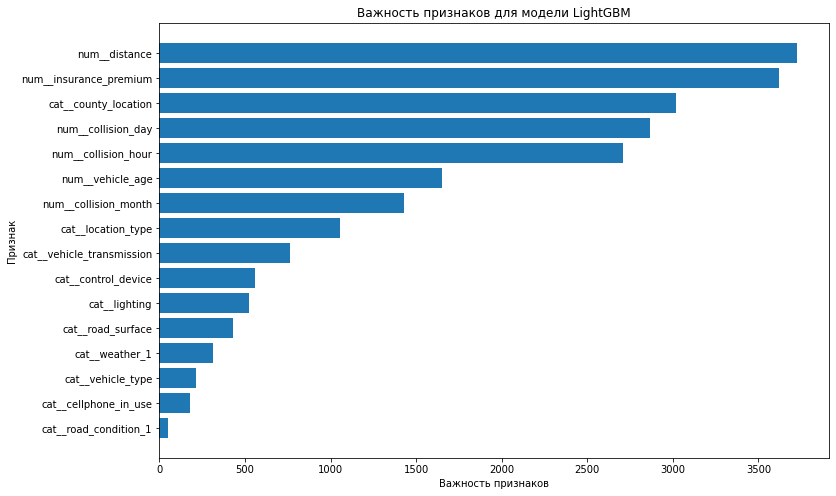

In [44]:
importance_type = 'split'
feature_importance = pd.DataFrame({
    'feature': results['LightGBM']['model'].feature_name(),
    'importance': results['LightGBM']['model'].feature_importance(importance_type=importance_type)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.ylabel('Признак')
plt.xlabel('Важность признаков')
plt.title('Важность признаков для модели LightGBM')
plt.gca().invert_yaxis()
plt.show()

    Модель больше всего обращает внимание на такие признаки как:

        -Сумма страховки 
        -Расстояние от главной дороги
        -Дата происшествия (определенный день)

In [45]:
print(data['at_fault'].corr(data['insurance_premium']).round(3))

-0.135


    Никакой корреляции не наблюдается между самым важным признаком и таргетом, но раз модель использует этот признак, можно попробовать ввести какой-нибудь обязательный страховой взнос или залог, также можно придумать более гибкую систему залога, при которой, например, в праздники залог будет выше. 

    З.Ы. На самом деле не очень понятно, что конкретно значит сумма страховки, кто эту сумму оплачивает и в каком случае, оплачивает ли это пользователь при аварии за автомобиль или оплачивает компания за ремонт, а с пользователя берется какой-либо залог изначально

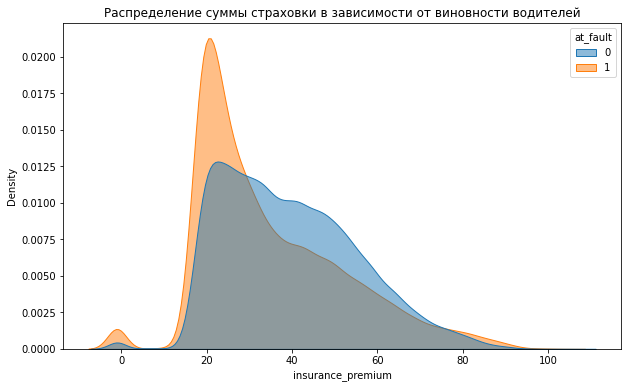

In [46]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='insurance_premium', hue='at_fault', fill=True, alpha=0.5)
plt.title('Распределение суммы страховки в зависимости от виновности водителей')
plt.show()

    Исходя из графика, могу предложить добавить бОльшую сумму залога или страховки, на графике много нарушителей, которые взнос не делали вовсе,
    возможно, конечно, это повлияет на прибыль, но можно придумать какую-нибдуь систему поощрения водителей, которые не нарушают, добавить им скидки
    или же дать возможность делать маленькие взносы, добавить систему прогресса, при котором сам пользователь будет видеть, что за правильную езду у него будет поощрения, пусть это будет система мотивации
        

### Шаг 7. Общий вывод по модели

        -Лучшей моделью для оценки риска ДТП в данном проекте оказался LightGBM с метрикой F1-score = 0.9154, что свидетельствует о высокой точности и сбалансированности предсказаний.Наибольший вклад в прогноз вносит сумма страховки водителя, что может косвенно отражать его опыт, историю вождения или стоимость автомобиля.
        -Добавить адекватную систему оценки при выдачи авто, я думаю, возможно, исходя из оценки важности признаков модели можно добавить залог перед использованием машины, хотя бы для новых пользователей.
        -Чтобы улучшить модель, нужно добавить такие данные как стаж водителя, возраст, если возможно, то историю нарушений